<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/text_to_image/imagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imagen

In [ ]:
!pip install -q imagen-pytorch

In [8]:
import torch
from imagen_pytorch import Unet, Imagen
import numpy as np
from PIL import Image
import tensorflow as tf
import collections
import random
import os
import json

In [5]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 422s 0us/step


In [6]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

In [9]:
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [10]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:1000]
print(len(train_image_paths))

6000


<start> A cat looking at it''s own reflection in a mirror. <end>


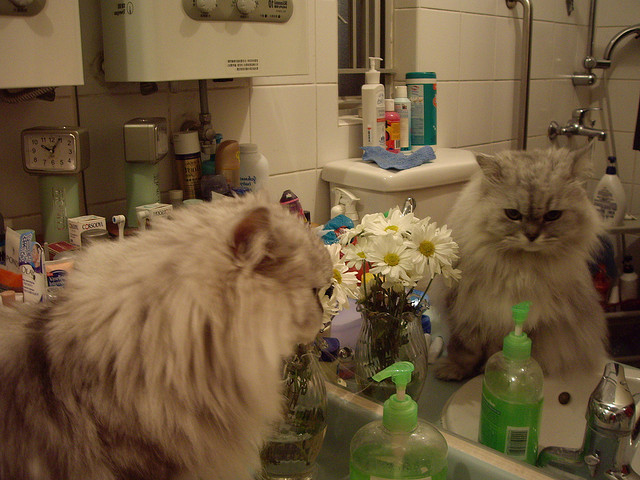

In [11]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

In [15]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.keras.layers.Resizing(256, 256)(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img

In [65]:
images = []
texts = []

for i in range(10):
  img = load_image(train_image_paths[i])
  img = np.array(img)
  img = np.swapaxes(img, 0, 2)
  images.append(img)

  texts.append(train_captions[i])
  
images = np.array(images)

In [66]:
print(images.shape)
print(len(texts))

(10, 3, 256, 256)
10


In [ ]:
unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

imagen = Imagen(
    unets = (unet1, unet2),
    image_sizes = (64, 256),
    beta_schedules = ('cosine', 'linear'),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

# text_embeds = torch.randn(4, 256, 768).cuda()
# text_masks = torch.ones(4, 256).bool().cuda()
# images = torch.randn(4, 3, 256, 256).cuda()
images = torch.asarray(images).cuda()

for _ in range(100):
  for i in (1, 2):
    loss = imagen(images, texts = texts, unet_number = i)
    loss.backward()

images = imagen.sample(texts = [
    'a whale breaching from afar'
], cond_scale = 2.)

images.shape # (1, 3, 256, 256)

In [ ]:
from google.colab.patches import cv2_imshow

img = np.array(images[0].cpu() * 255, dtype=np.uint8)
img

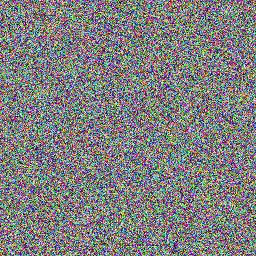

In [76]:
noise = np.random.rand(256, 256, 3)

cv2_imshow(np.array(noise * 255, dtype=np.uint8))

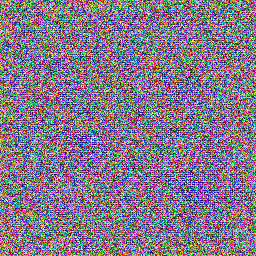

In [55]:
cv2_imshow(np.transpose(img, (1, 2, 0)))